## Gerekli kütüphanelerin içe aktarılması

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, auc
import warnings
warnings.filterwarnings('ignore')

## Bölüm 1: Veri Ön İşleme (Preprocessing)

### 1. Veri Setinin Yüklenmesi ve Keşfi

In [ ]:
# Veri setinin yüklenmesi
df = pd.read_excel("/content/drive/MyDrive/DryBeanDataset/Dry_Bean_Dataset.xlsx")

# Veri setinin keşfi
print("Veri setinin boyutu:", df.shape)
print("\nİlk 5 satır:")
print(df.head())
print("\nVeri tipleri:")
print(df.dtypes)
print("\nTemel istatistikler:")
print(df.describe())
print("\nSınıf dağılımı:")
print(df['Class'].value_counts())

# Eksik değer kontrolü
print("\nEksik değerler:")
print(df.isnull().sum())

Veri setinin boyutu: (13611, 17)

İlk 5 satır:
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  Shape

Veri setinde 13,611 örnek ve 17 özellik bulunuyor. Hedef değişken "Class" sütunudur ve farklı kuru fasulye türlerini temsil eder.


---


Sınıf dağılımına bakıldığında, veri setinde 7 farklı fasulye çeşidi bulunuyor: DERMASON (3546), SIRA (2636), SEKER (2027), HOROZ (1928), CALI (1630), BARBUNYA (1322) ve BOMBAY (522). Orijinal veri setinde hiç eksik değer bulunmamaktadır.

### 2. Eksik Değerler Ekleme ve İşleme

In [ ]:
df_missing = df.copy()

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

selected_cols_5p = np.random.choice(numerical_cols, 2, replace=False)
print(f"% 5 eksik değer eklenecek sütunlar: {selected_cols_5p}")

for col in selected_cols_5p:
    df_missing.loc[df_missing.sample(frac=0.05).index, col] = np.nan

remaining_cols = [col for col in numerical_cols if col not in selected_cols_5p]
selected_col_35p = np.random.choice(remaining_cols, 1)[0]
print(f"% 35 eksik değer eklenecek sütun: {selected_col_35p}")

df_missing.loc[df_missing.sample(frac=0.35).index, selected_col_35p] = np.nan

print("\nEksik değerleri doğrulama")
print(df_missing.isnull().sum())

% 5 eksik değer eklenecek sütunlar: ['MajorAxisLength', 'ShapeFactor4']
% 35 eksik değer eklenecek sütun: Extent

Eksik değerleri doğrulama
Area                  0
Perimeter             0
MajorAxisLength     681
MinorAxisLength       0
AspectRation          0
Eccentricity          0
ConvexArea            0
EquivDiameter         0
Extent             4764
Solidity              0
roundness             0
Compactness           0
ShapeFactor1          0
ShapeFactor2          0
ShapeFactor3          0
ShapeFactor4        681
Class                 0
dtype: int64


Bu adımda, rasgele seçilen iki sütuna %5 oranında eksik değerler ekledik (MajorAxisLength ve ShapeFactor4) ve bir sütuna %35 oranında eksik değerler ekledik (Extent).

Gerçek dünya verilerinde sıklıkla karşılaştığımız durumları simüle etmek için yapılıdı.

### 3. Eksik Değerleri İşleme

Bu adımda, önceki adımda eklenen eksik değerleri iki farklı strateji kullanarak işliyoruz:

In [ ]:
# %5 eksik veriye sahip sütunları medyan ile doldurma
for col in selected_cols_5p:
    median_value = df_missing[col].median()
    df_missing[col].fillna(median_value, inplace=True)
    print(f"{col} sütunundaki eksik değerler medyan ile dolduruldu: {median_value}")

# %35 eksik veriye sahip sütun için satırları silme
print(f"Satır sayısı (çıkarmadan önce): {df_missing.shape[0]}")
df_missing.dropna(subset=[selected_col_35p], inplace=True)
print(f"Satır sayısı (çıkardıktan sonra): {df_missing.shape[0]}")

print("\nİşleme sonrasında eksik değerler:")
print(df_missing.isnull().sum())

MajorAxisLength sütunundaki eksik değerler medyan ile dolduruldu: 297.34755669456416
ShapeFactor4 sütunundaki eksik değerler medyan ile dolduruldu: 0.9963794315614631
Satır sayısı (çıkarmadan önce): 13611
Satır sayısı (çıkardıktan sonra): 8847

İşleme sonrasında eksik değerler:
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


1. Az miktarda (%5) eksik değere sahip sütunlar için medyan değerle doldurma stratejisi kullanıyoruz. Bu, veri kaybını en aza indirirken veri dağılımını korumaya yardımcı olur.
2. Yüksek miktarda (%35) eksik değere sahip sütun için ise eksik değer içeren satırları silme stratejisi kullanıyoruz. Bu, 13,611 satırı 8,847 satıra düşürdü, ancak kalan verinin kalitesini korudu.

### 4. Aykırı Değerleri Belirleme ve İşleme

Bu adımda, aykırı değerleri (outliers) belirleme ve işleme üzerine odaklanıyoruz. Aykırı değerler, veri setindeki normal değerlerden önemli ölçüde farklı olan değerlerdir ve makine öğrenmesi modellerinin performansını olumsuz etkileyebilirler.


---
IQR (Çeyrekler Arası Aralık) yöntemini kullanarak aykırı değerleri belirliyoruz ve sonra bu değerleri alt ve üst sınırlara çekerek (capping) işliyoruz.

Area: 362 aykırı değer tespit edildi
Perimeter: 329 aykırı değer tespit edildi
MajorAxisLength: 254 aykırı değer tespit edildi
MinorAxisLength: 369 aykırı değer tespit edildi
AspectRation: 309 aykırı değer tespit edildi
Eccentricity: 533 aykırı değer tespit edildi
ConvexArea: 361 aykırı değer tespit edildi
EquivDiameter: 347 aykırı değer tespit edildi
Extent: 181 aykırı değer tespit edildi
Solidity: 511 aykırı değer tespit edildi
roundness: 59 aykırı değer tespit edildi
Compactness: 72 aykırı değer tespit edildi
ShapeFactor1: 341 aykırı değer tespit edildi
ShapeFactor2: 0 aykırı değer tespit edildi
ShapeFactor3: 122 aykırı değer tespit edildi
ShapeFactor4: 534 aykırı değer tespit edildi


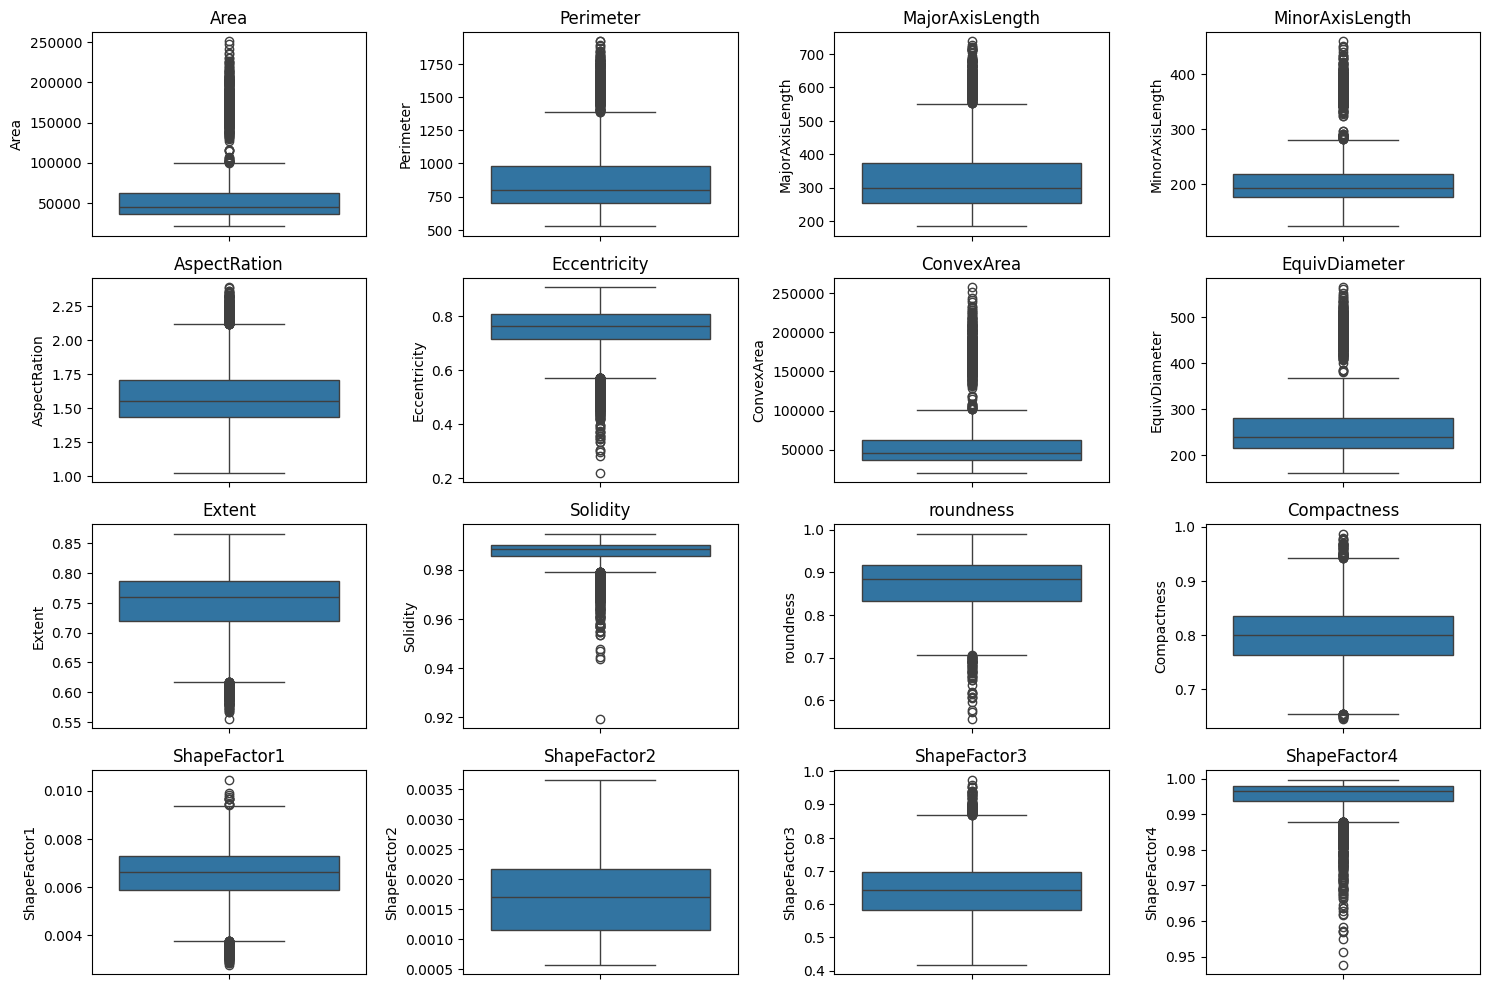

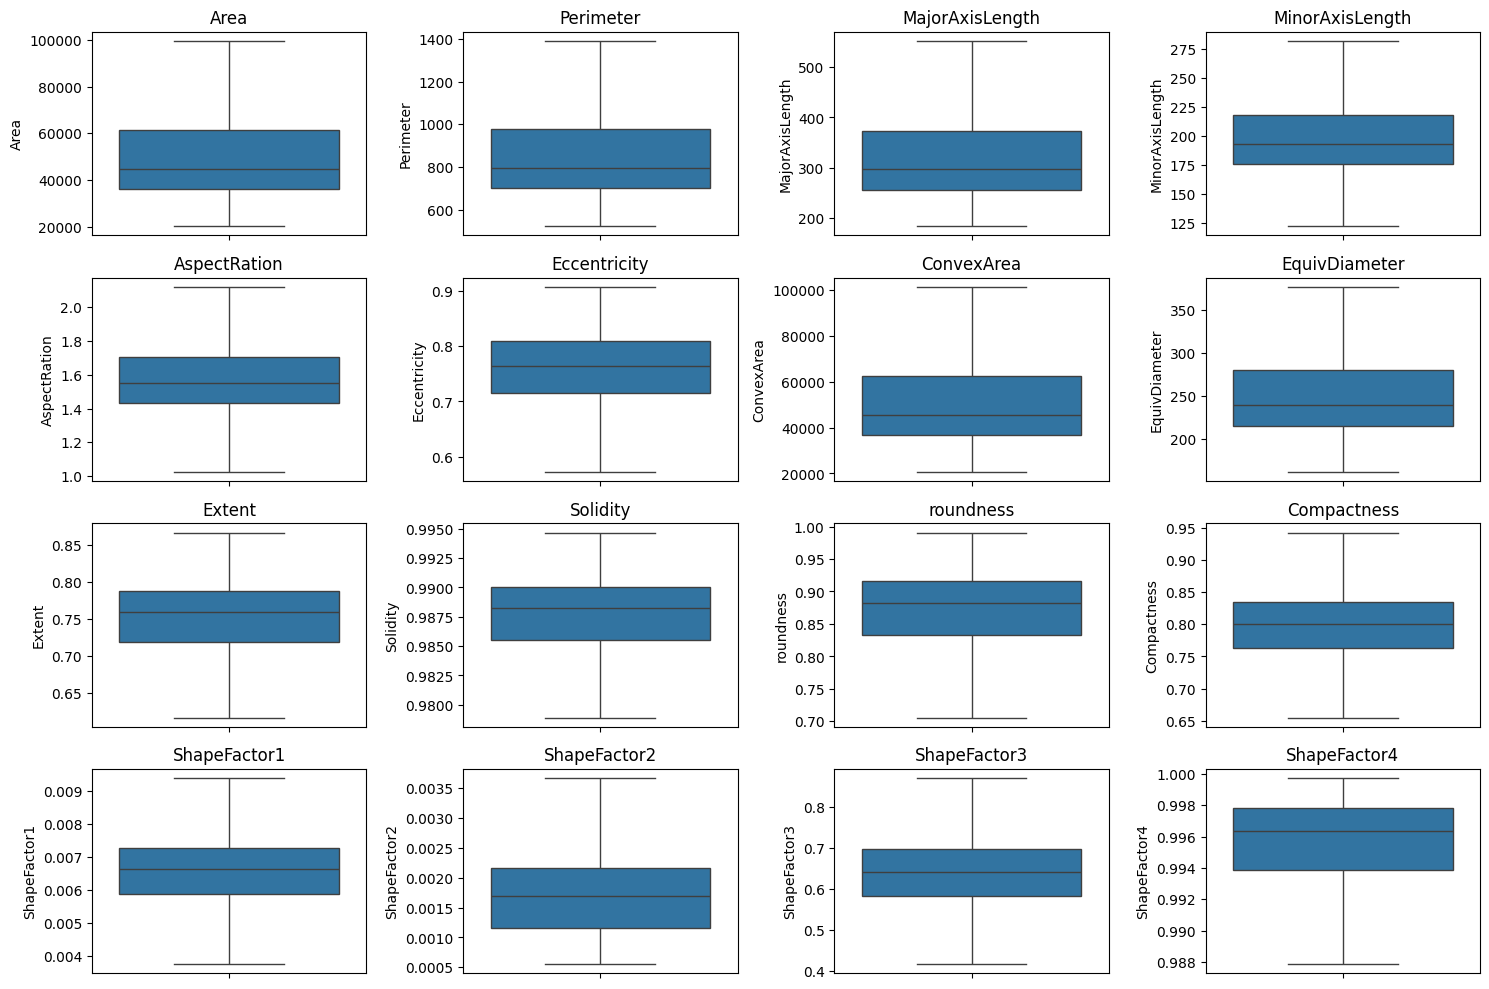

In [ ]:
# IQR yöntemi kullanarak aykırı değerleri belirleme fonksiyonu
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Aykırı değerleri sınırlama ile işleme fonksiyonu
def handle_outliers(df, column, lower_bound, upper_bound):
    df_copy = df.copy()
    df_copy.loc[df_copy[column] < lower_bound, column] = lower_bound
    df_copy.loc[df_copy[column] > upper_bound, column] = upper_bound
    return df_copy

# Her sayısal sütun için aykırı değerleri sayma ve görselleştirme
plt.figure(figsize=(15, 10))
numerical_cols = df_missing.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

for i, column in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df_missing[column])
    plt.title(column)
plt.tight_layout()
plt.savefig('aykiri_degerler_boxplot.png')

# Tüm sayısal sütunlar için aykırı değerleri işleme
df_no_outliers = df_missing.copy()
for column in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df_missing, column)
    print(f"{column}: {len(outliers)} aykırı değer tespit edildi")
    df_no_outliers = handle_outliers(df_no_outliers, column, lower_bound, upper_bound)

# Aykırı değerlerin işlendiğini doğrulama
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df_no_outliers[column])
    plt.title(column)
plt.tight_layout()
plt.savefig('aykiri_degerler_sonrasi.png')

Boxplot kullanarak, işlem öncesi ve sonrası aykırı değerlerin dağılımını görselleştiriyoruz. Bu grafikler, outlier'ların başarılı bir şekilde işlendiğini doğrulamaktadır.

## Bölüm 2: Özellik Seçimi ve Boyut İndirgeme

### 5. Özellik Seçimi

Bu adımda, modelleme aşamasına hazırlık için özellik seçimi yapıyoruz:

1. Veri setini özellikler (X) ve hedef değişken (y) olarak ayırıyoruz.
2. Hedef değişken kategorik olduğundan, makine öğrenmesi algoritmaları için sayısal değerlere dönüştürmek amacıyla LabelEncoder kullanıyoruz. Bu, her fasulye sınıfına bir numara atar (örn. BARBUNYA: 0, BOMBAY: 1, vb.).
3. Sayısal özellikler için StandardScaler kullanarak ölçeklendirme yapıyoruz. Bu, tüm özellikleri aynı ölçeğe getirir ve bu da algoritmaların daha iyi performans göstermesine yardımcı olur.

In [ ]:
# Özellikler ve hedef değişkenin ayrıştırılması
X = df_no_outliers.drop('Class', axis=1)
y = df_no_outliers['Class']

# Hedef değişken için etiket kodlama
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Kodlanmış sınıflar: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Sayısal özellikler için standart ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# İşlenmiş veri setini oluşturma (bu, ön işlemeden sonraki "ham" veri setimiz olacak)
X_raw = X_scaled.copy()

Kodlanmış sınıflar: {'BARBUNYA': 0, 'BOMBAY': 1, 'CALI': 2, 'DERMASON': 3, 'HOROZ': 4, 'SEKER': 5, 'SIRA': 6}


### 6. Boyut İndirgeme: PCA (Temel Bileşenler Analizi)

Bu adımda, boyut indirgeme tekniklerinden PCA'yı uyguluyoruz. PCA, yüksek boyutlu veriyi daha düşük boyutlu bir uzaya dönüştürmek için kullanılır
bu da modellerin eğitim süresini azaltır.

---

Sonuçlar:

Her bir bileşenin açıklanan varyans oranını hesapladık ve görselleştirdik.
Ortalama açıklanan varyans değeri (0.062) üzerindeki bileşenleri seçtik, bu da bize 3 temel bileşen verdi.
İlk iki bileşeni kullanarak veriyi görselleştirdik, bu da sınıfların uzaydaki dağılımını görmemizi sağladı.

PCA'nın avantajı, daha az sayıda değişkenle veri setindeki varyansın büyük kısmını koruyabilmesidir. Bu örnekte, 16 özellikten sadece 3'ünü kullanarak verinin önemli kısmını muhafaza ettik.

Seçilen PCA bileşen sayısı (açıklanan varyans > ortalama): 3


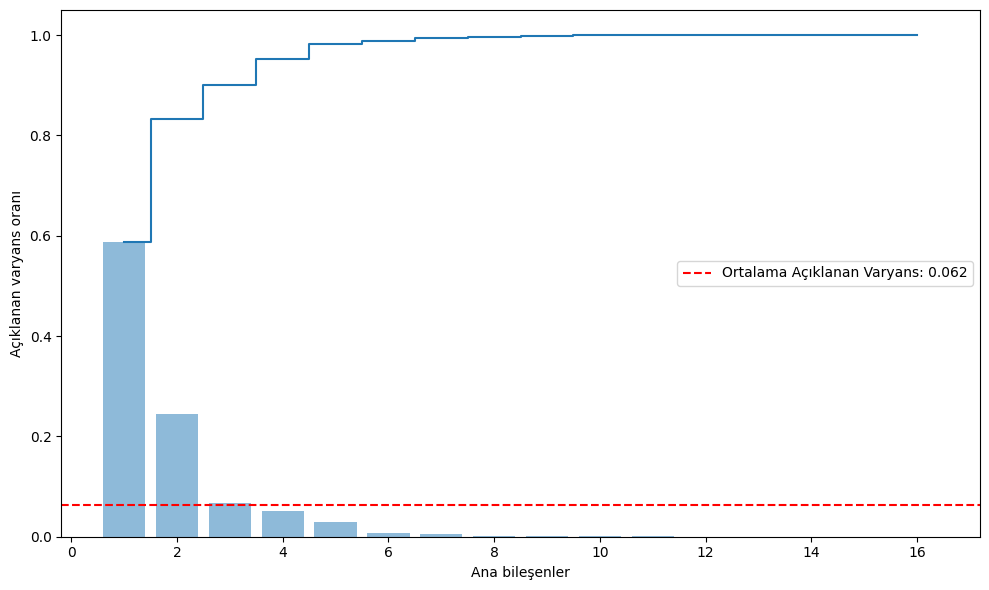

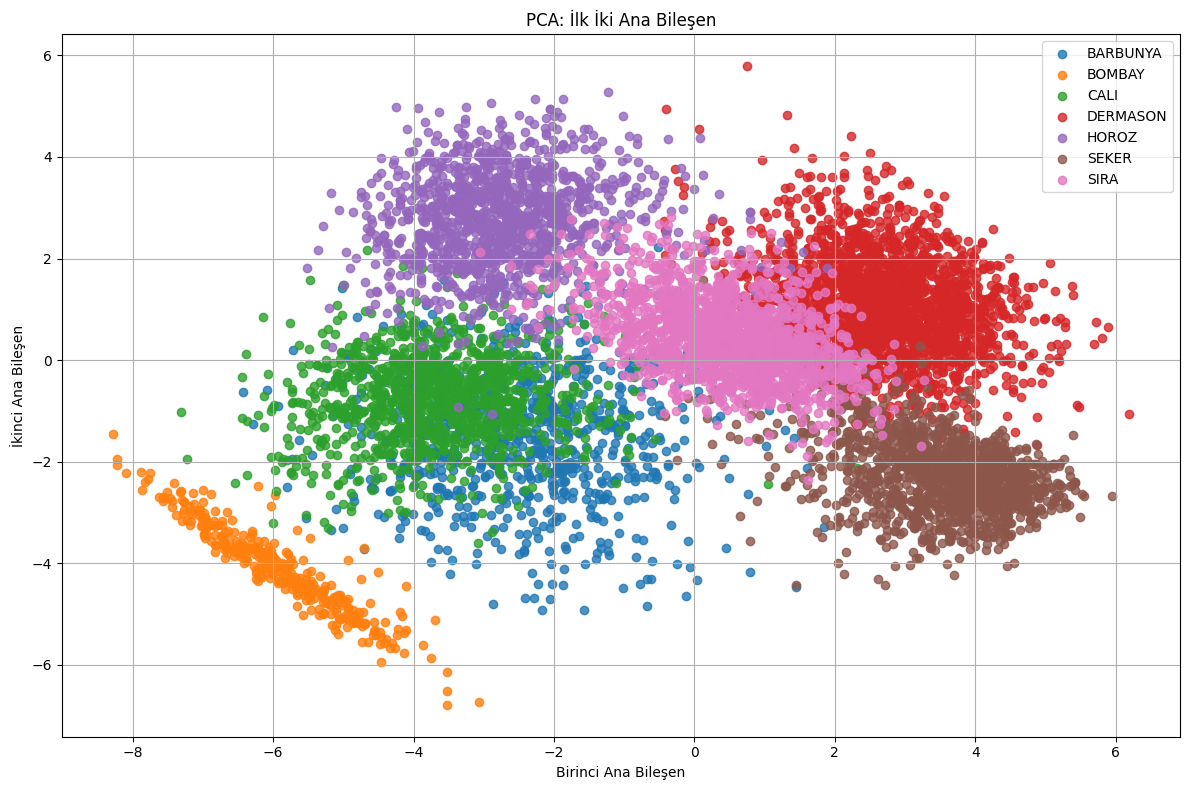

In [ ]:
# PCA uygulama
pca = PCA()
X_pca_full = pca.fit_transform(X_raw)

# Açıklanan varyans oranı hesaplama
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Açıklanan varyansı görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid')
plt.axhline(y=np.mean(explained_variance), color='r', linestyle='--',
            label=f'Ortalama Açıklanan Varyans: {np.mean(explained_variance):.3f}')
plt.ylabel('Açıklanan varyans oranı')
plt.xlabel('Ana bileşenler')
plt.legend()
plt.tight_layout()
plt.savefig('pca_aciklanan_varyans.png')

# Ortalama varyansdan büyük açıklanan varyansa sahip bileşenleri seçme
mean_variance = np.mean(explained_variance)
num_components = sum(explained_variance > mean_variance)
print(f"Seçilen PCA bileşen sayısı (açıklanan varyans > ortalama): {num_components}")

# Seçilen bileşen sayısı ile PCA uygulama
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_raw)

# İlk iki bileşenin görselleştirilmesi
plt.figure(figsize=(12, 8))
for i, target_class in enumerate(np.unique(y_encoded)):
    indices = np.where(y_encoded == target_class)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1],
                label=le.inverse_transform([target_class])[0], alpha=0.8)
plt.title('PCA: İlk İki Ana Bileşen')
plt.xlabel('Birinci Ana Bileşen')
plt.ylabel('İkinci Ana Bileşen')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_gorselleştirme.png')

### 7. Boyut İndirgeme: LDA (Doğrusal Diskriminant Analizi)

Bu adımda, PCA'dan farklı olarak gözetimli bir boyut indirgeme tekniği olan LDA'yı uyguluyoruz. LDA, veri noktalarını sınıflar arasında en iyi ayrımı sağlayacak şekilde dönüştürmeye çalışır.

LDA'nın avantajı, sadece varyansı değil, aynı zamanda sınıf ayrımını da dikkate almasıdır. Bu örnekte, 3 LDA bileşeni oluşturduk ve ilk iki bileşeni kullanarak verideki sınıfların dağılımını görselleştirdik. Görselleştirme, sınıfların LDA uzayında nasıl kümelendiğini göstermektedir.

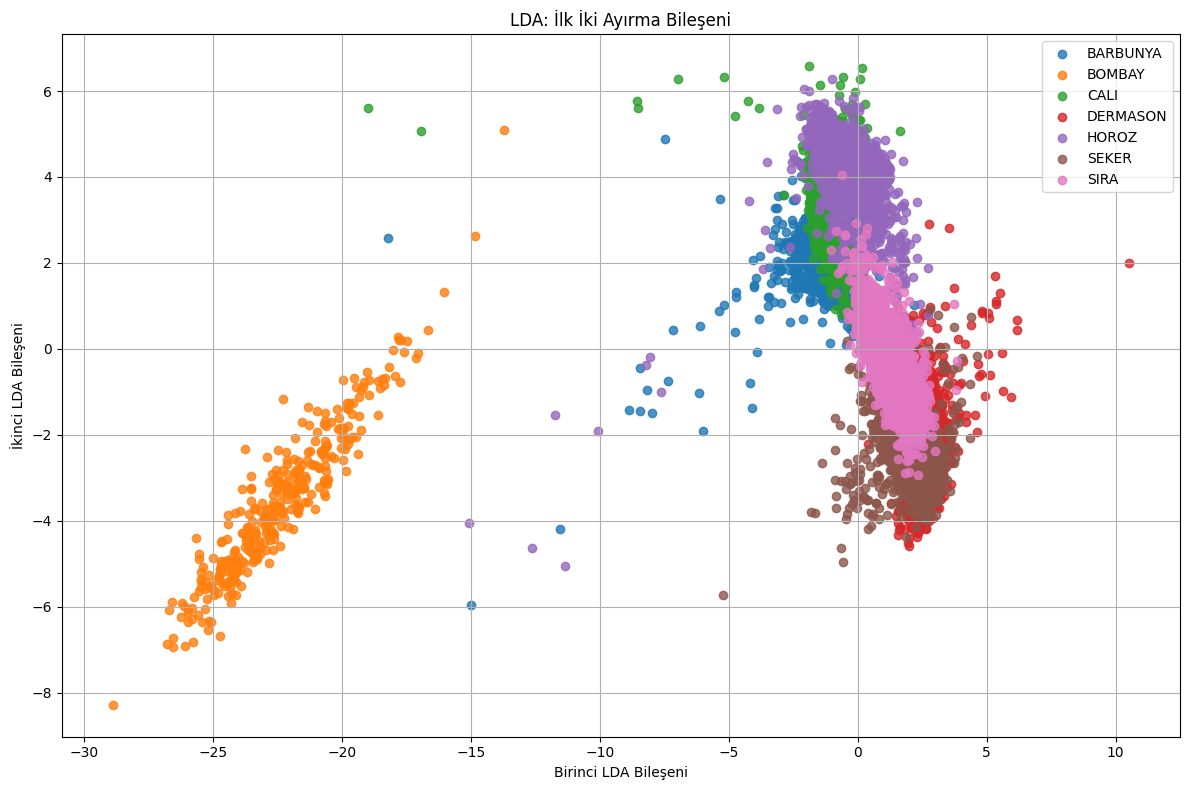

In [ ]:
# 3 bileşenli LDA uygulama
n_classes = len(np.unique(y_encoded))
n_components = min(3, n_classes - 1)  # LDA bileşenleri n_classes - 1'den fazla olamaz
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(X_raw, y_encoded)

# LDA bileşenlerinin görselleştirilmesi
plt.figure(figsize=(12, 8))
for i, target_class in enumerate(np.unique(y_encoded)):
    indices = np.where(y_encoded == target_class)
    if X_lda.shape[1] >= 2:  # En az 2 bileşenimiz varsa
        plt.scatter(X_lda[indices, 0], X_lda[indices, 1],
                    label=le.inverse_transform([target_class])[0], alpha=0.8)
    else:  # Sadece 1 bileşenimiz varsa
        plt.scatter(X_lda[indices, 0], np.zeros(len(indices[0])),
                    label=le.inverse_transform([target_class])[0], alpha=0.8)
plt.title('LDA: İlk İki Ayırma Bileşeni')
plt.xlabel('Birinci LDA Bileşeni')
plt.ylabel('İkinci LDA Bileşeni')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lda_gorselleştirme.png')

## Bölüm 3: Modelleme ve Değerlendirme

### 8. Model Eğitimi ve Değerlendirme

Bu adımda, çeşitli makine öğrenmesi modellerini farklı veri temsilleri üzerinde eğitiyoruz. Modellerimizi 3 farklı veri temsili için eğitiyoruz:

Ham veri (standart ölçeklendirilmiş)
PCA ile boyut indirgenmiş veri
LDA ile boyut indirgenmiş veri

Hiperparametre optimizasyonu için iç içe çapraz doğrulama (nested cross-validation) kullanıyoruz. Bu, her model ve her veri temsili için en iyi hiperparametreleri bulmamıza yardımcı olur.
Bu süreç, modelleri 5 katlı çapraz doğrulama ile değerlendirir ve her katta 3 katlı iç çapraz doğrulama ile hiperparametreleri optimize eder. Bu, daha güvenilir performans tahminleri sağlar ve overfitting engeller.

In [ ]:
# Veri temsillerini başlatma
data_representations = {
    'Raw Data': X_raw,
    'PCA': X_pca,
    'LDA': X_lda
}

# Hiperparametre ızgaraları ile modelleri tanımlama
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=10000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    }
}

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# İç içe çapraz doğrulama
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Sonuçlar sözlüğü
results = {}

for rep_name, X_rep in data_representations.items():
    print(f"\n{rep_name} için iç içe çapraz doğrulama başlatılıyor...")
    results[rep_name] = {}

    # ROC eğrileri için
    best_models = {}

    for model_name, model_info in models.items():
        print(f"  - {model_name} işleniyor...")
        results[rep_name][model_name] = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1_score': [],
            'test_predictions': [],
            'test_true': []
        }

        for train_idx, test_idx in outer_cv.split(X_rep):
            X_train, X_test = X_rep[train_idx], X_rep[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

            # Hiperparametre ayarlama için iç döngü
            grid_search = GridSearchCV(
                estimator=model_info['model'],
                param_grid=model_info['params'],
                cv=inner_cv,
                scoring='accuracy',
                n_jobs=-1
            )

            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            # Tahminler
            y_pred = best_model.predict(X_test)

            # Metrikleri hesaplama
            metrics = calculate_metrics(y_test, y_pred)

            # Metrikleri ve tahminleri saklama
            for metric_name, metric_value in metrics.items():
                results[rep_name][model_name][metric_name].append(metric_value)

            results[rep_name][model_name]['test_predictions'].append(y_pred)
            results[rep_name][model_name]['test_true'].append(y_test)

            # Bu kat için en iyi modeli saklama (ROC eğrileri için kullanılacak)
            if model_name not in best_models or metrics['accuracy'] > best_models[model_name]['accuracy']:
                best_models[model_name] = {
                    'model': best_model,
                    'accuracy': metrics['accuracy'],
                    'test_idx': test_idx,
                    'y_test': y_test
                }

    # Bu temsil için en iyi modelleri saklama
    results[rep_name]['best_models'] = best_models


Raw Data için iç içe çapraz doğrulama başlatılıyor...
  - Logistic Regression işleniyor...
  - Decision Tree işleniyor...
  - Random Forest işleniyor...
  - XGBoost işleniyor...
  - Naive Bayes işleniyor...

PCA için iç içe çapraz doğrulama başlatılıyor...
  - Logistic Regression işleniyor...
  - Decision Tree işleniyor...
  - Random Forest işleniyor...
  - XGBoost işleniyor...
  - Naive Bayes işleniyor...

LDA için iç içe çapraz doğrulama başlatılıyor...
  - Logistic Regression işleniyor...
  - Decision Tree işleniyor...
  - Random Forest işleniyor...
  - XGBoost işleniyor...
  - Naive Bayes işleniyor...


### 9. Sonuçların Değerlendirilmesi

Bu adımda, önceki adımda eğitilen tüm modellerin performansını değerlendiriyoruz. Her model ve veri temsili için ortalama ve standart sapma ile birlikte doğruluk (accuracy), kesinlik (precision), duyarlılık (recall) ve F1 skoru hesaplıyoruz.


---


Sonuçlar:

Veri temsili yöntemlerinin model performansına etkisini incelediğimizde, ilk olarak ham verinin tüm metriklerde en yüksek başarıyı sunduğunu gözlemliyoruz. Doğruluk oranı 0,899 ile 0,922 arasında değişirken, precision, recall ve F1 skorları da benzer şekilde üst düzey değerler alıyor. Bu durum, veri setindeki ayrıştırıcı özelliklerin tam boyutuyla kullanıldığında modellerin sınıfları en etkin şekilde ayırt edebildiğini gösteriyor.

Boyut indirgeme yöntemlerinden PCA uygulandığında performansta belirgin bir düşüş ortaya çıkıyor; doğruluk oranı 0,858–0,884 aralığına geriliyor. Ham veriye kıyasla yaklaşık %4–6’lık bir kayıp, bilgi bütünlüğünün azaltılmasının sınıflandırma başarısına doğrudan yansıdığını ortaya koyuyor. Buna karşın LDA ile elde edilen sonuçlar, PCA’den de daha düşük performans veriyor: Doğruluk 0,826–0,870 aralığında seyrederken, ham veriye göre %5–10 civarında daha büyük bir azalma görülüyor. LDA’da sınıflar arası ayrımı güçlendiren algoritmanın bu veri seti için optimal olmadığı ve önemli varyasyonları gözden kaçırdığı sonucuna varılabilir.

Bu sonuçlar, bu veri seti için boyut indirgemenin bilgi kaybına neden olduğunu ve ham verinin doğrudan kullanılmasının daha iyi sonuçlar verdiğini göstermektedir.

In [ ]:
# Metrikler için ortalama ve standart sapma hesaplama fonksiyonu
def calculate_stats(metric_list):
    return np.mean(metric_list), np.std(metric_list)

# Performans özeti oluştur
performance_summary = pd.DataFrame(columns=['Data Representation', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Dataframe'e eklenecek sonuçları saklayacak liste
results_list = []

for rep_name in results:
    for model_name in models:
        if model_name in results[rep_name]:
            acc_mean, acc_std = calculate_stats(results[rep_name][model_name]['accuracy'])
            prec_mean, prec_std = calculate_stats(results[rep_name][model_name]['precision'])
            rec_mean, rec_std = calculate_stats(results[rep_name][model_name]['recall'])
            f1_mean, f1_std = calculate_stats(results[rep_name][model_name]['f1_score'])

            results_list.append({
                'Data Representation': rep_name,
                'Model': model_name,
                'Accuracy': f"{acc_mean:.3f} ± {acc_std:.3f}",
                'Precision': f"{prec_mean:.3f} ± {prec_std:.3f}",
                'Recall': f"{rec_mean:.3f} ± {rec_std:.3f}",
                'F1 Score': f"{f1_mean:.3f} ± {f1_std:.3f}"
            })

# Sonuçlar listesini DataFrame'e dönüştür ve birleştir
performance_summary = pd.concat([performance_summary, pd.DataFrame(results_list)], ignore_index=True)

# Performans özetini yazdır ve kaydet
print("\nPerformans Özeti:")
print(performance_summary)
performance_summary.to_csv('performans_ozeti.csv', index=False)

# Find the best model overall
best_rep = None
best_model = None
best_accuracy = -1

for rep_name in results:
    for model_name in models:
        if model_name in results[rep_name]:
            acc_mean = np.mean(results[rep_name][model_name]['accuracy'])
            if acc_mean > best_accuracy:
                best_accuracy = acc_mean
                best_rep = rep_name
                best_model = model_name

print(f"\nEn iyi model: {best_model} ile {best_rep}, Accuracy: {best_accuracy:.3f}")


Performans Özeti:
   Data Representation                Model       Accuracy      Precision  \
0             Raw Data  Logistic Regression  0.922 ± 0.007  0.923 ± 0.007   
1             Raw Data        Decision Tree  0.902 ± 0.009  0.903 ± 0.009   
2             Raw Data        Random Forest  0.916 ± 0.004  0.916 ± 0.003   
3             Raw Data              XGBoost  0.921 ± 0.006  0.922 ± 0.006   
4             Raw Data          Naive Bayes  0.899 ± 0.007  0.900 ± 0.007   
5                  PCA  Logistic Regression  0.882 ± 0.007  0.882 ± 0.007   
6                  PCA        Decision Tree  0.858 ± 0.009  0.858 ± 0.009   
7                  PCA        Random Forest  0.880 ± 0.006  0.880 ± 0.007   
8                  PCA              XGBoost  0.884 ± 0.007  0.884 ± 0.007   
9                  PCA          Naive Bayes  0.872 ± 0.007  0.873 ± 0.007   
10                 LDA  Logistic Regression  0.836 ± 0.008  0.838 ± 0.009   
11                 LDA        Decision Tree  0.851 ± 0.00

### 10. ROC Eğrileri Oluşturma

Bu adımda her bir model-veri temsili kombinasyonu için sınıf bazında ROC eğrileri ve AUC değerleri hesaplanmıştır.


---

Sonuçlar:

ROC eğrilerine baktığımızda ham veri, hemen tüm sınıflar için neredeyse mükemmele yakın AUC değerleri sunuyor; Logistic Regression ve XGBoost modellerinde BARBUNYA, BOMBAY, CALI, HOROZ ve SEKER sınıfları için AUC=1,00 görülüyor, DERMASON ve SIRA’da bile 0,99’a ulaşılmış. PCA temsiliyle hâlâ yüksek AUC’ler elde edilse de, Decision Tree için 0,92–0,98 aralığında düşüşler ve diğer modellerde 0,97–1,00 bandında gerilemeler mevcut. LDA ise en düşük AUC performansını kaydediyor; özellikle SEKER sınıfında Logistic Regression ve Decision Tree’de sırasıyla 0,93 ve 0,92 AUC’ye gerileme görülürken, DERMASON sınıfında da 0,95–0,96 değerleriyle en kötü sonuçlar elde ediliyor.

Genel olarak, bu veri seti için boyut indirgeme yöntemlerinin bilgi kaybına yol açtığı, PCA’nin varyansa odaklanarak LDA’ya kıyasla daha başarılı sonuç verdiği, ancak her iki yöntemin de ham verinin yerini tutamadığı anlaşılıyor. Sınıf ayrımını en iyi Logistic Regression ve XGBoost modelleri gerçekleştiriyor. Sonuç olarak, boyut indirgeme yöntemleri yerine orijinal özellikleri kullanmak ve doğrusal ya da gradient boosting tabanlı modelleri tercih etmek, bu sorun için en etkili strateji olacaktır.


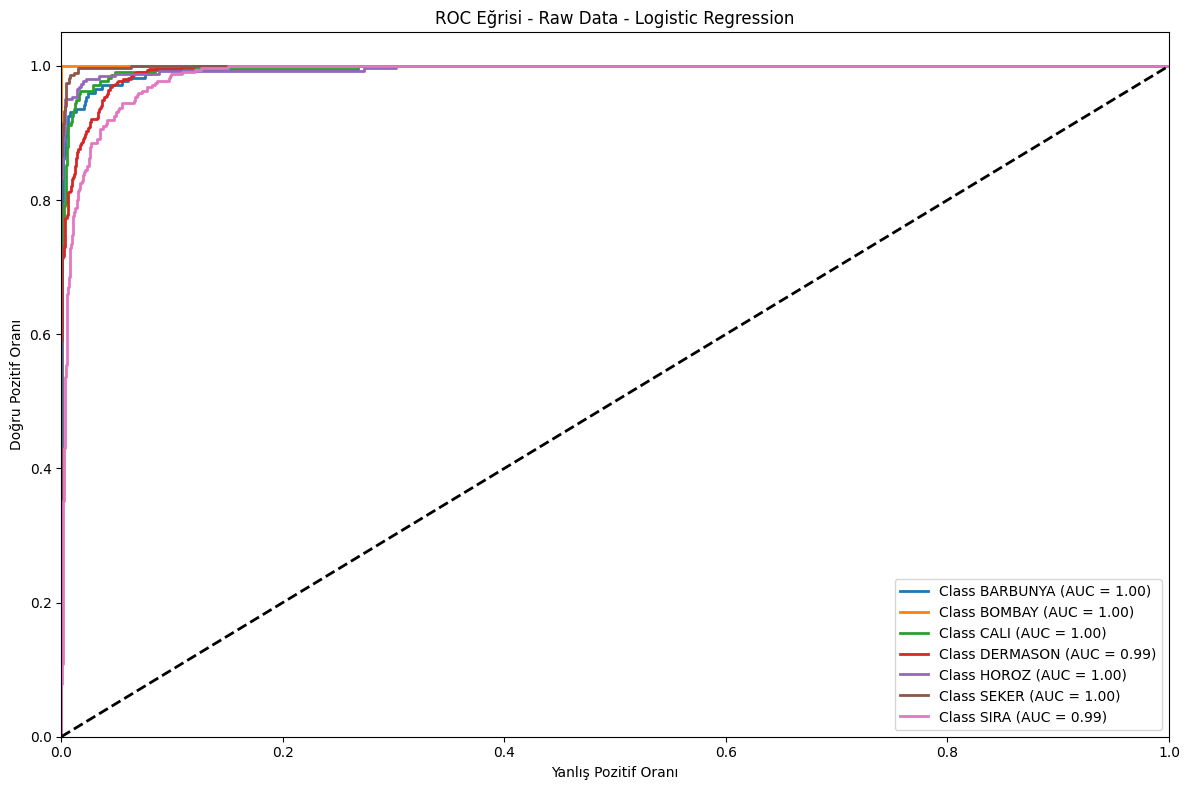

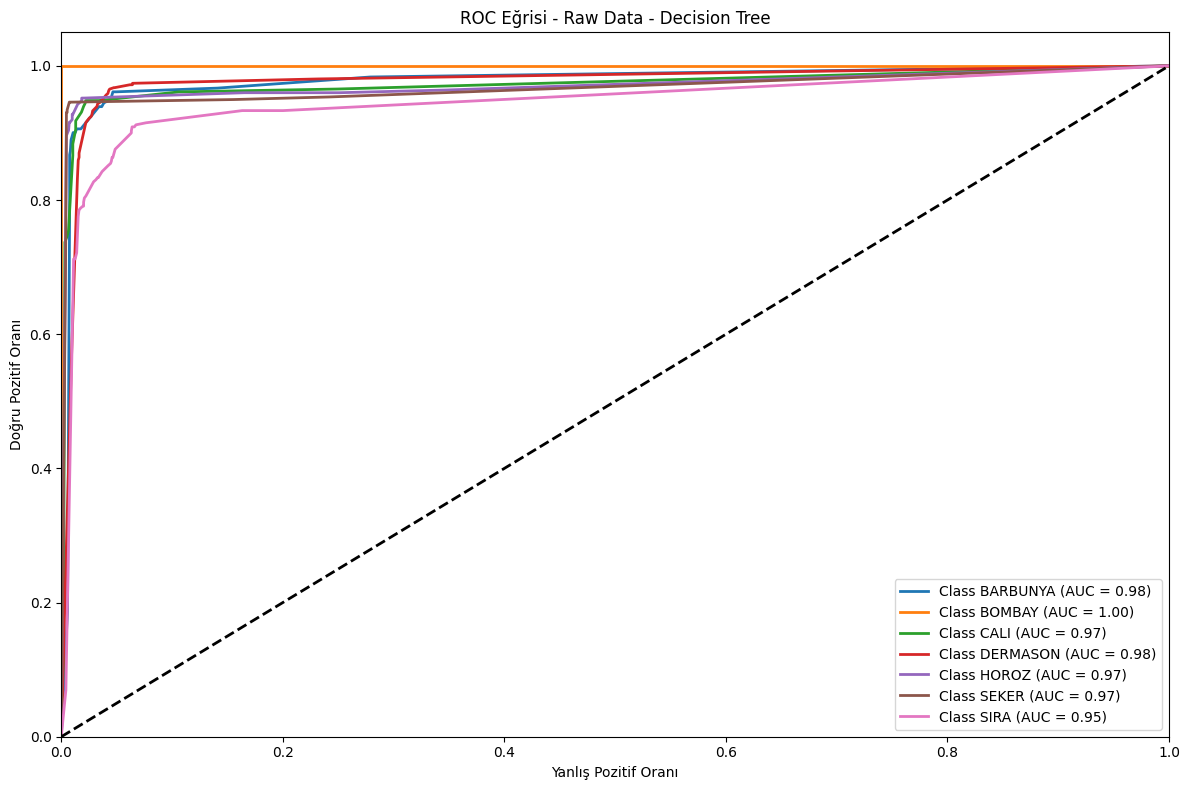

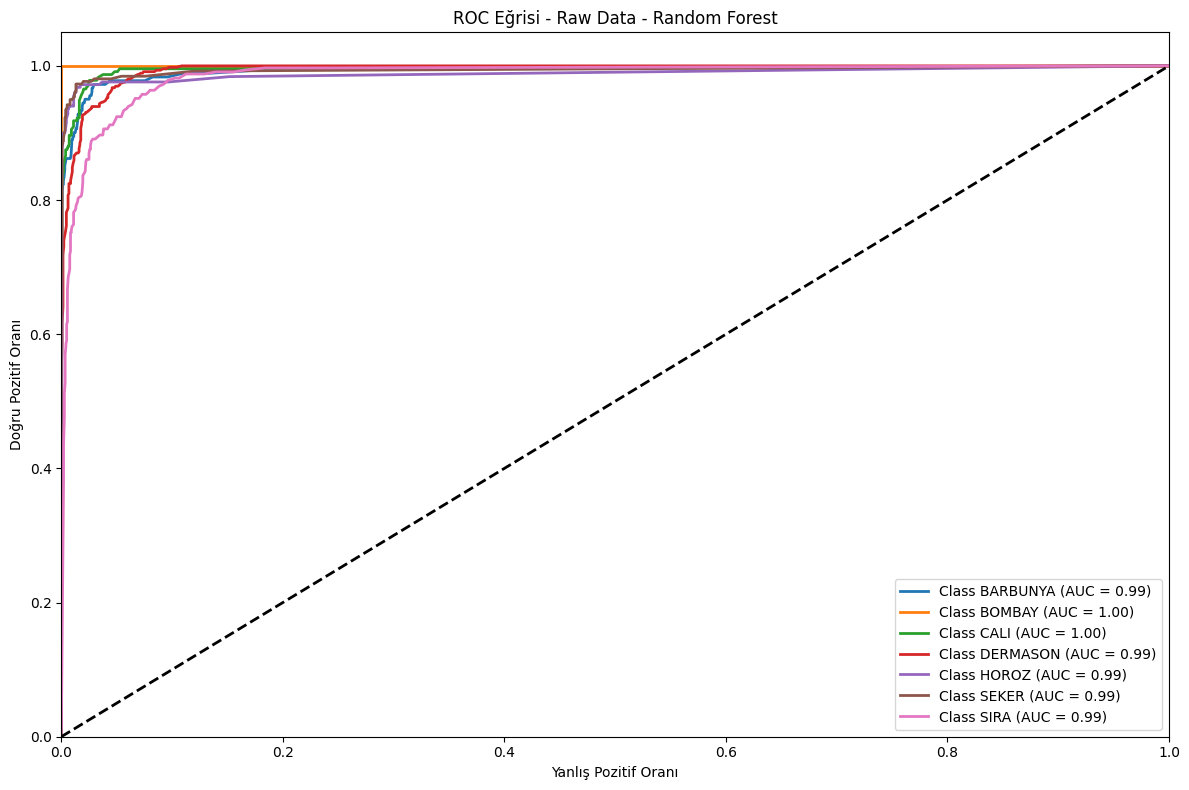

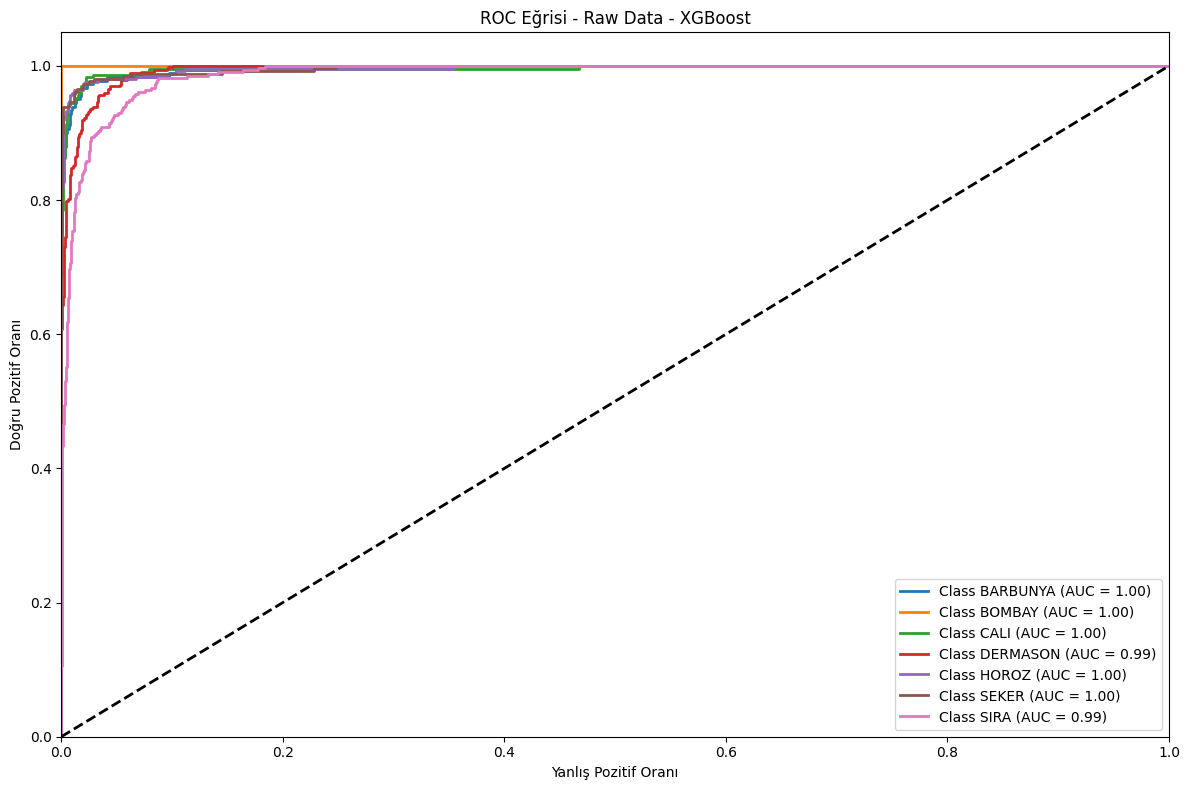

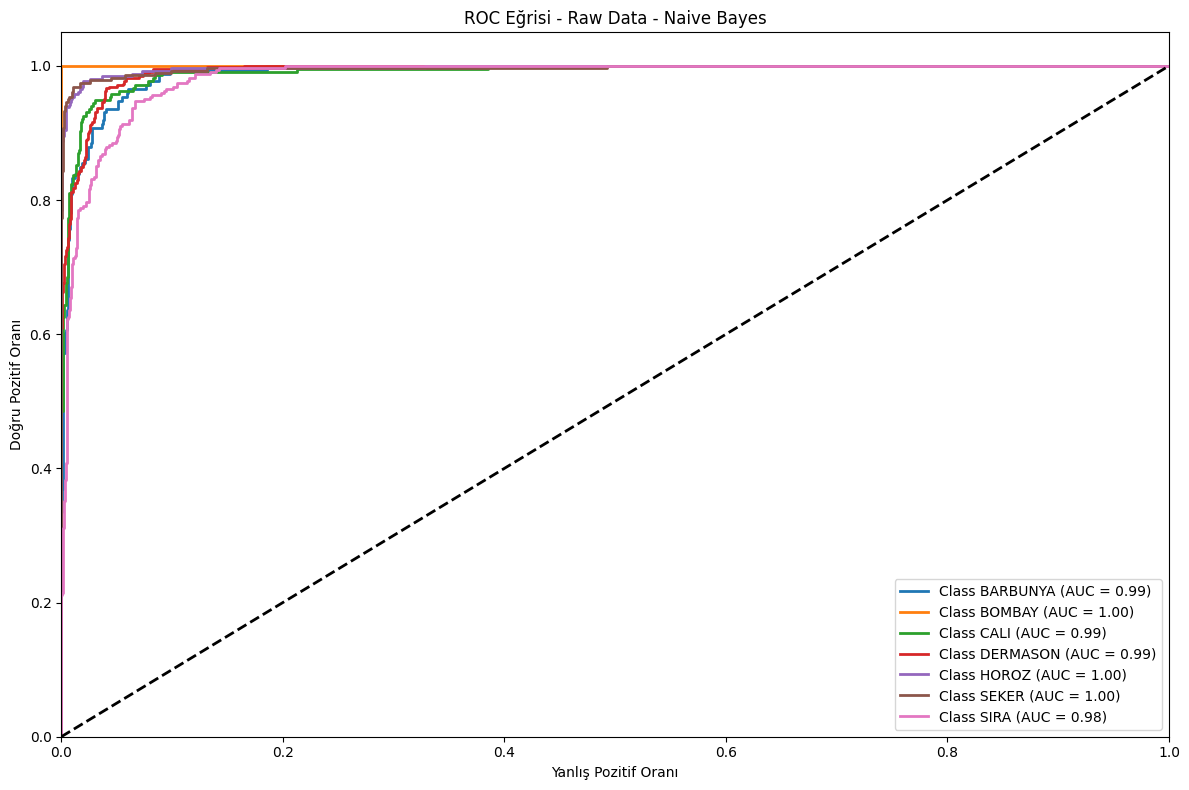

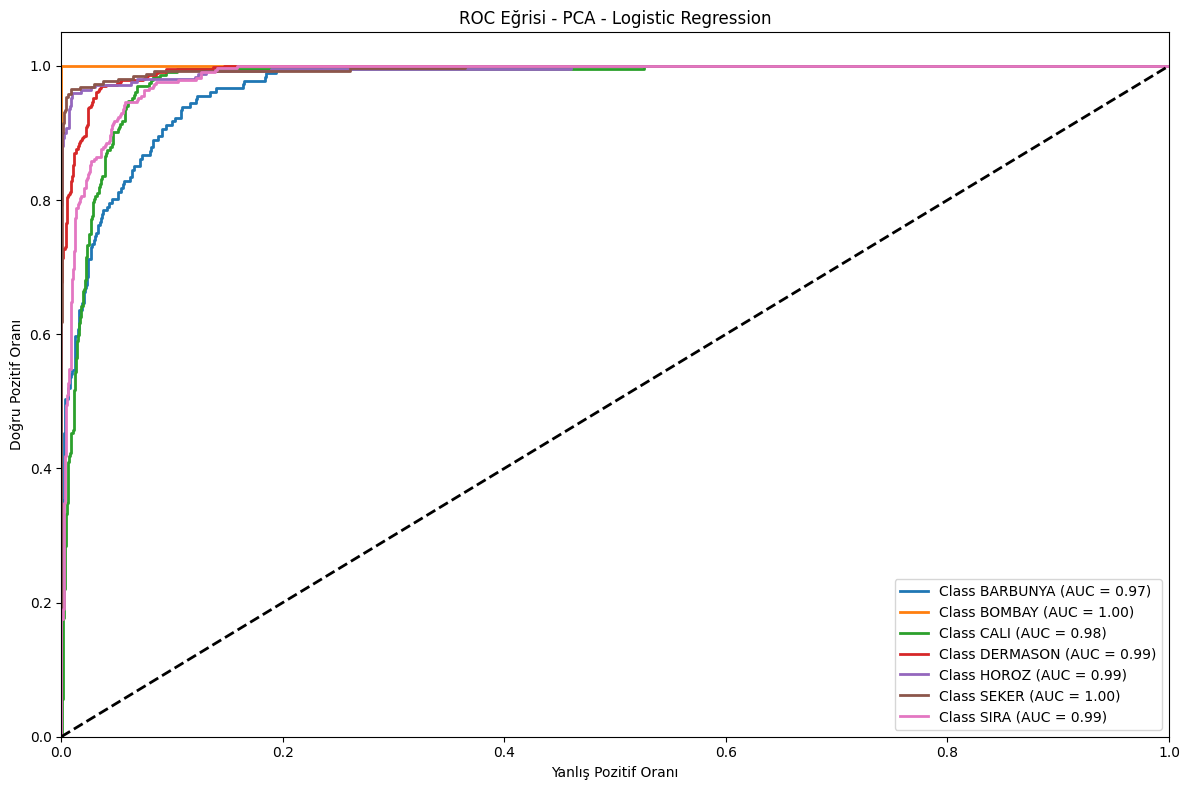

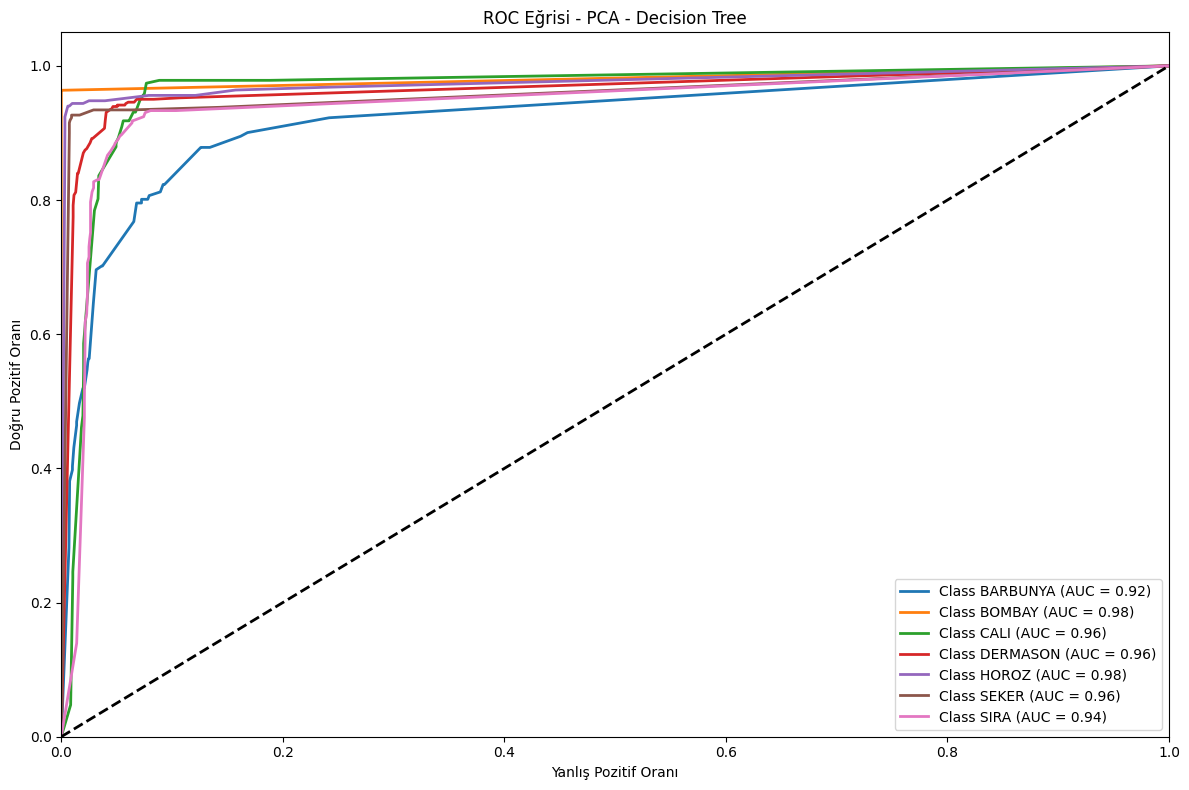

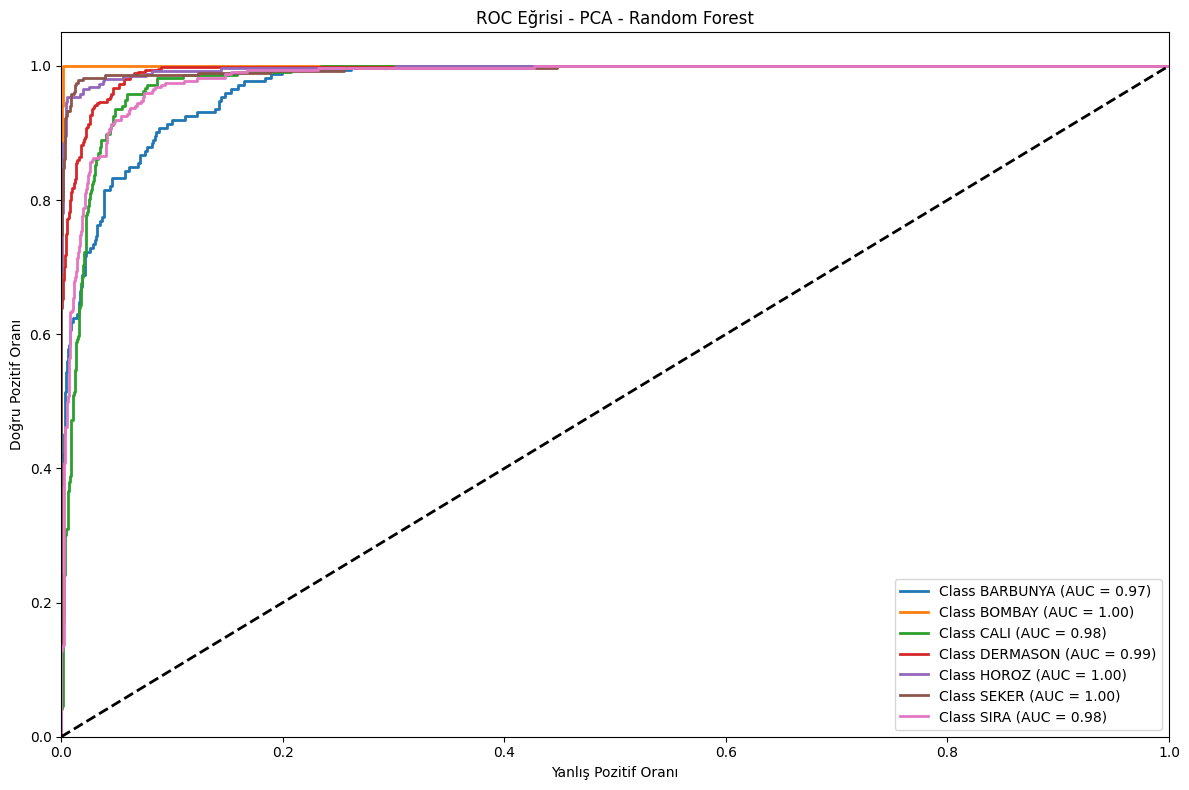

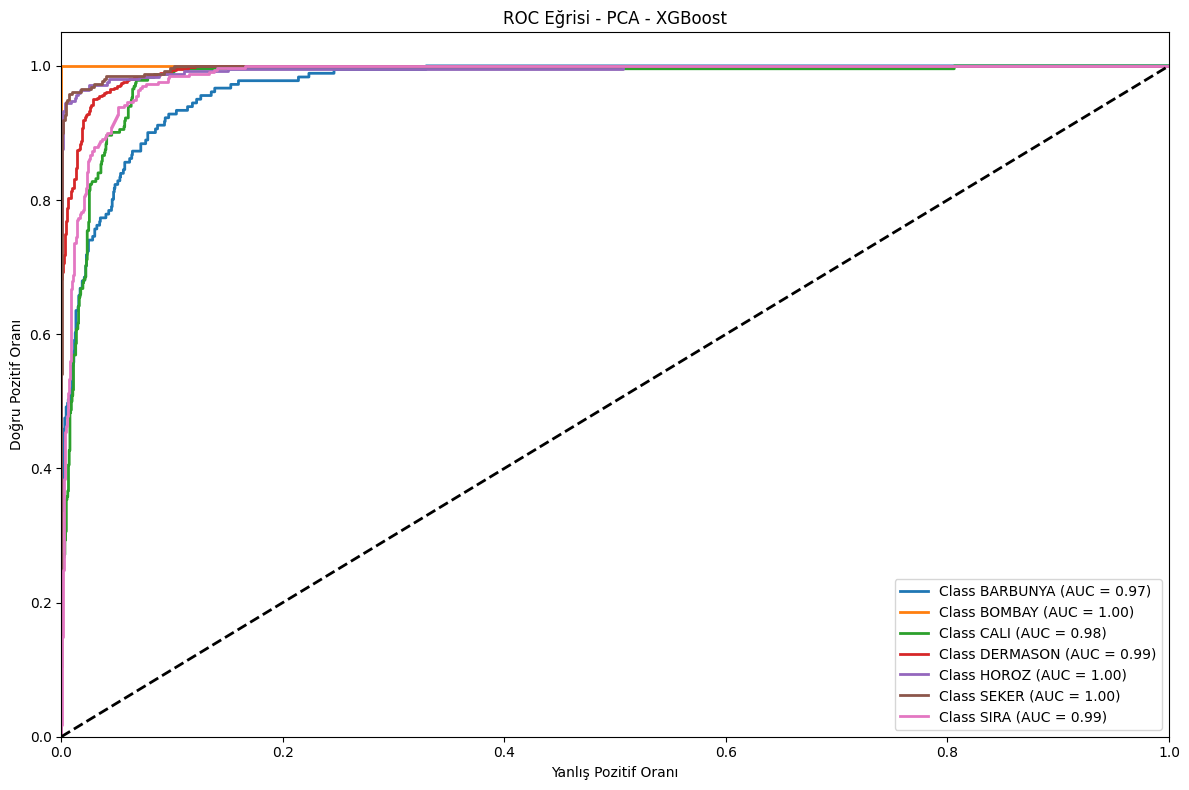

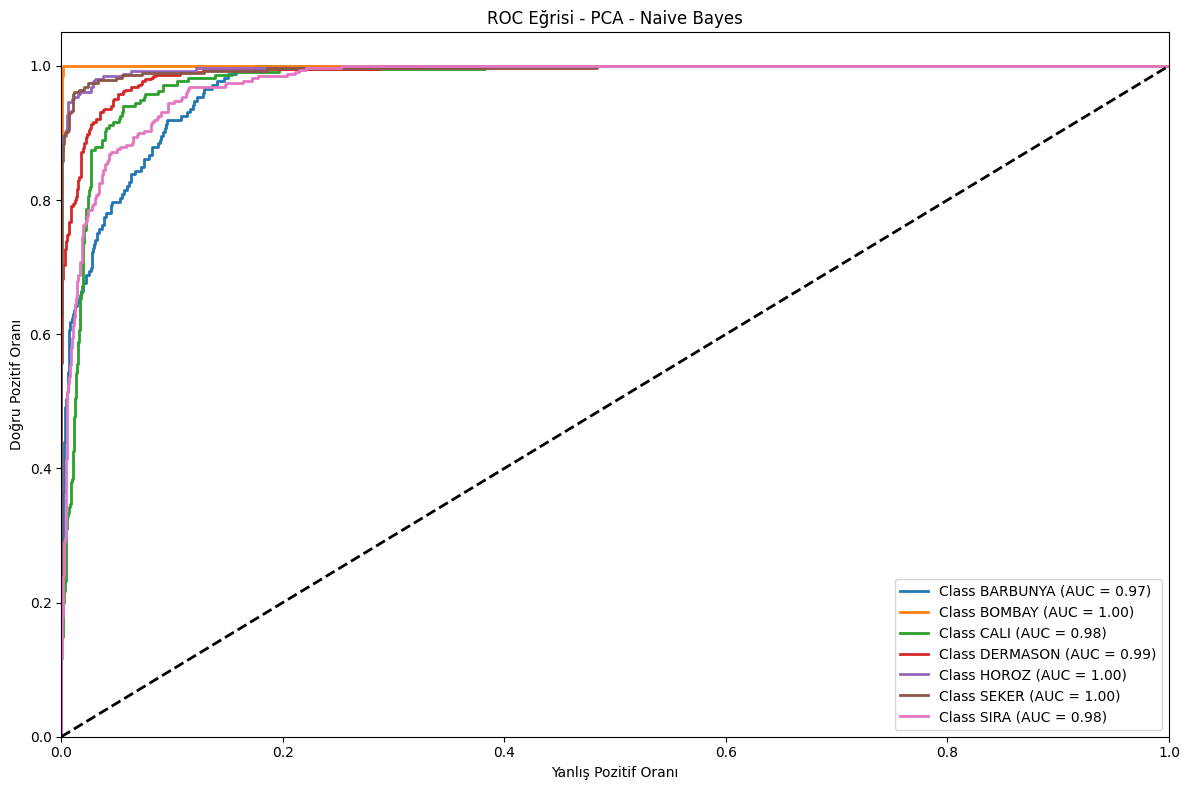

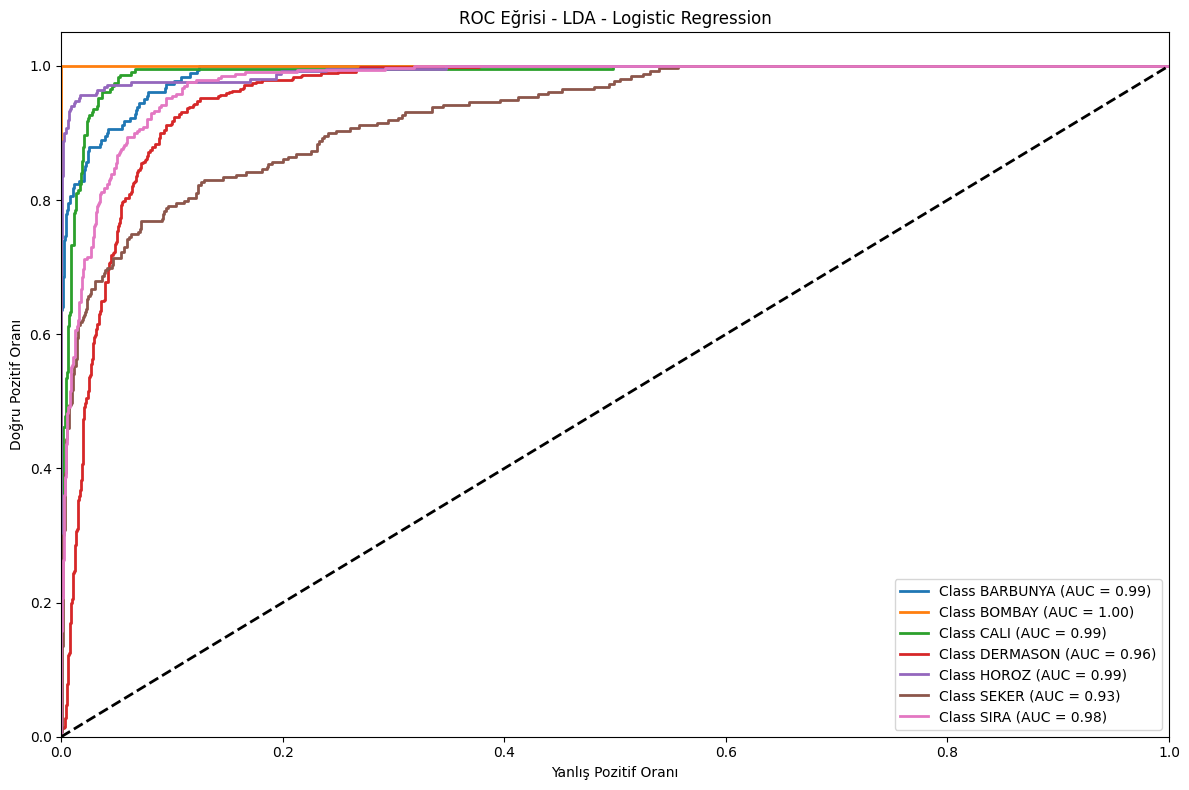

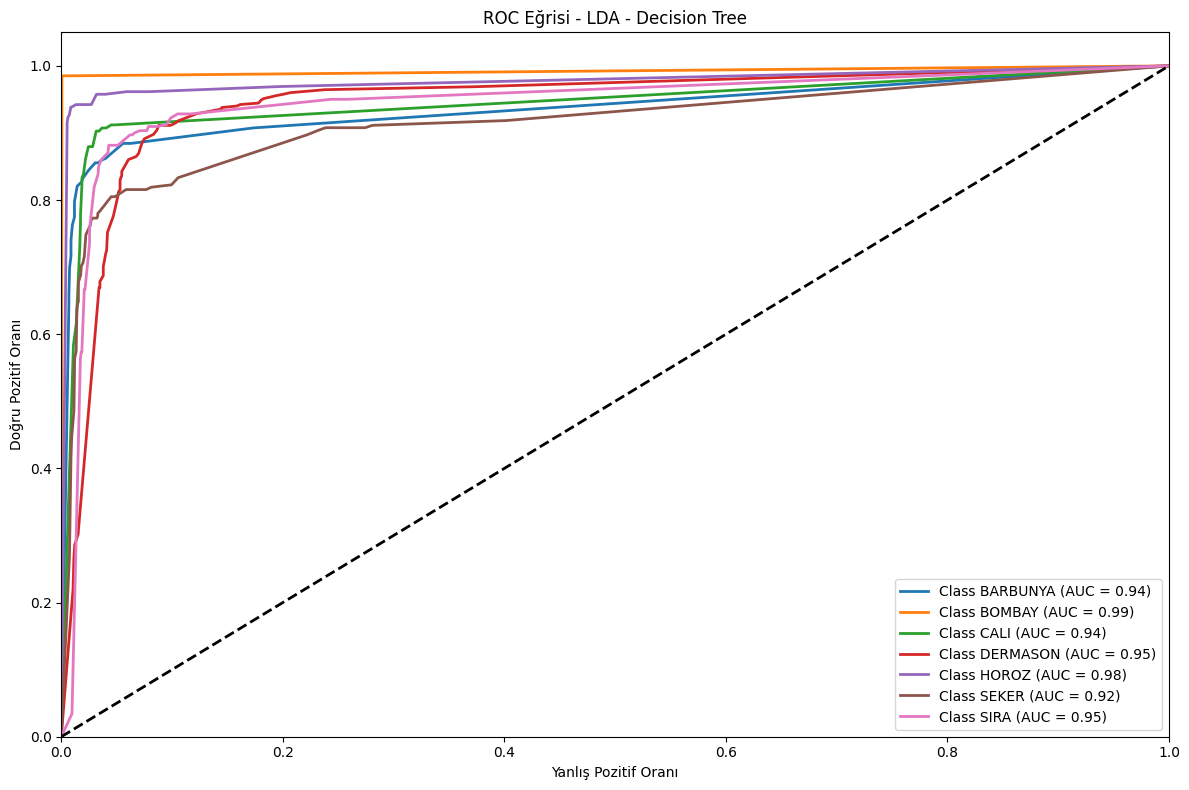

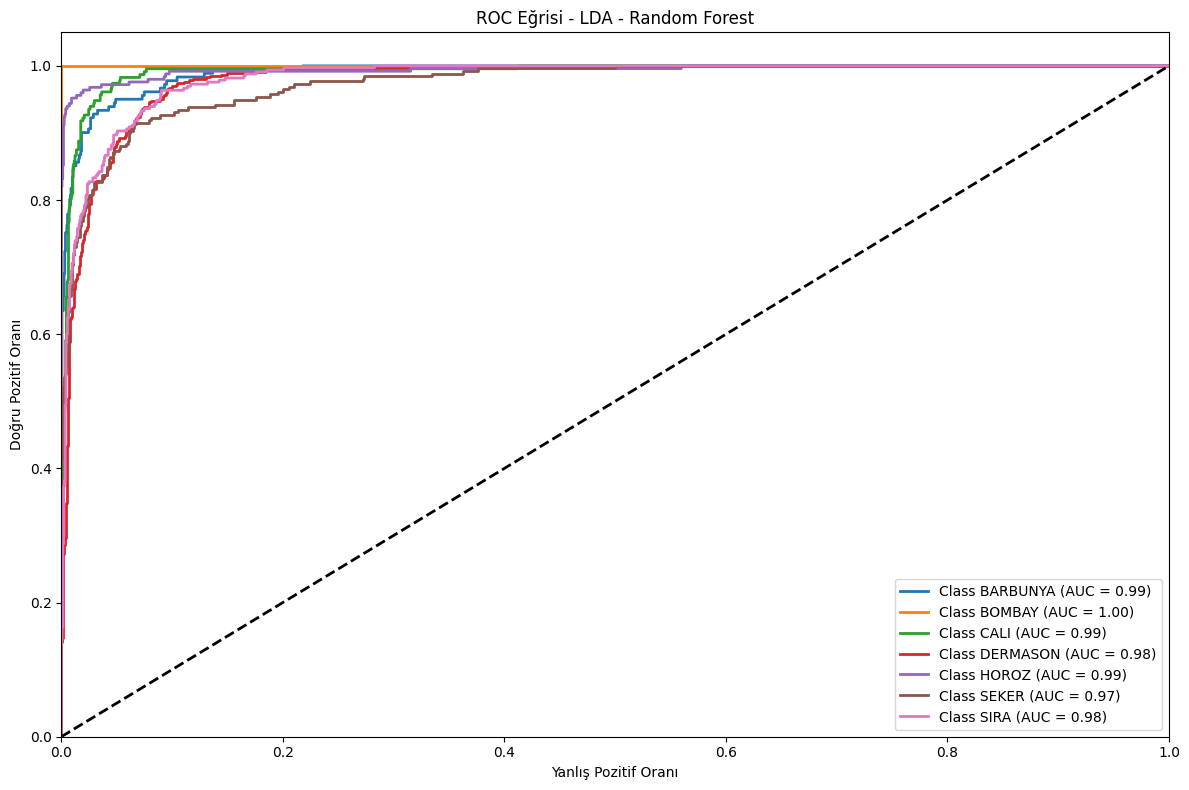

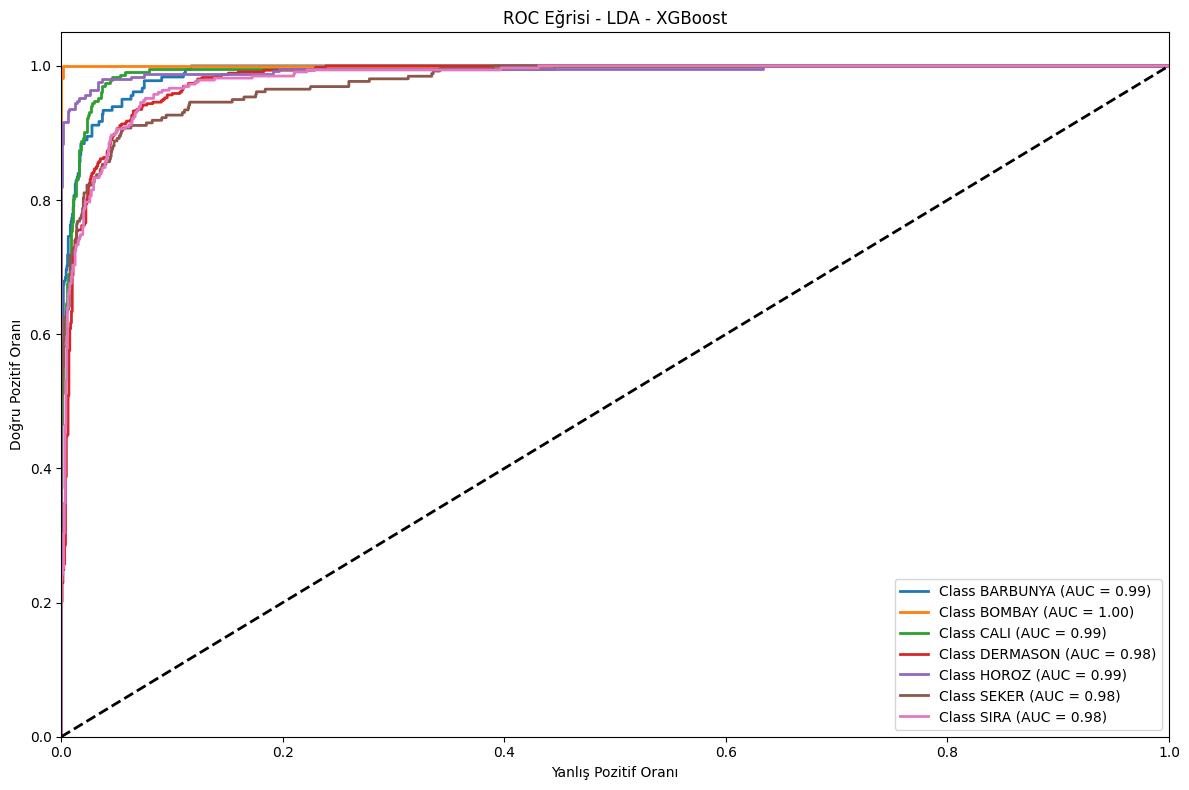

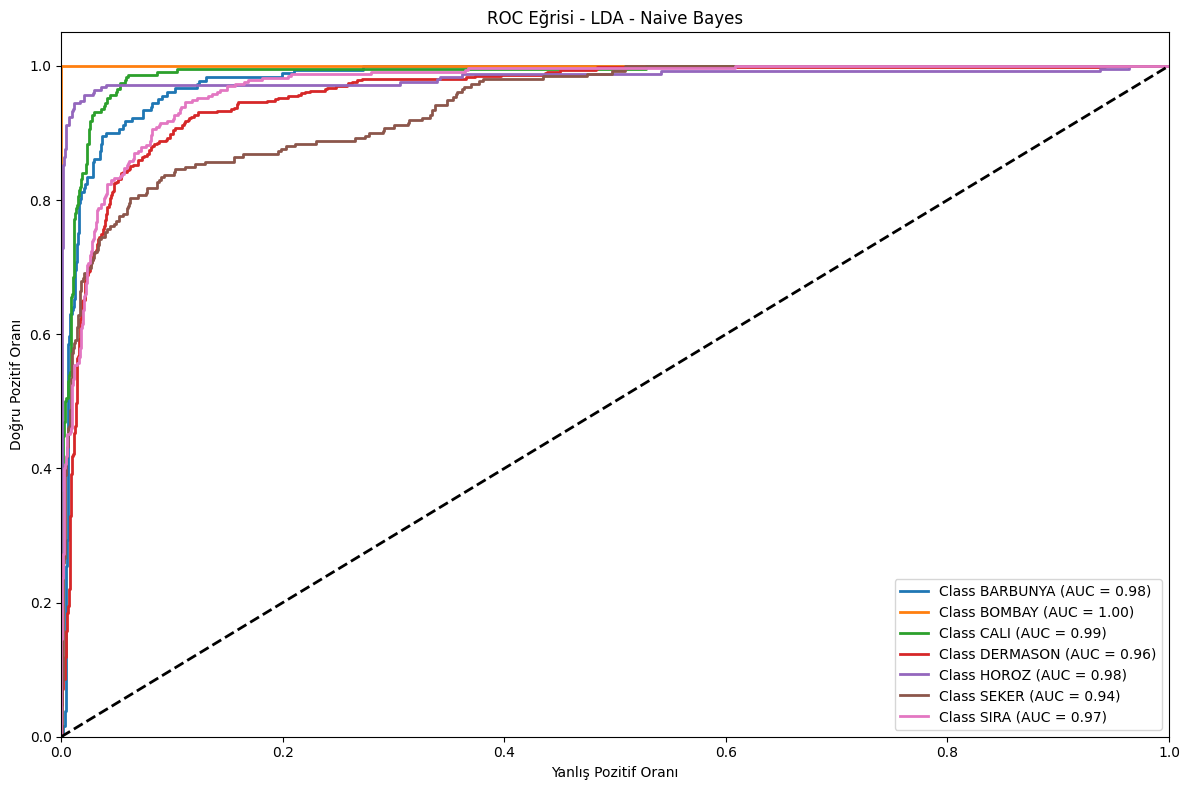

In [ ]:
# Her sınıf için ROC eğrileri oluşturma (One-vs-All yaklaşımı)
for rep_name in results:
    for model_name in results[rep_name]['best_models']:
        best_model_info = results[rep_name]['best_models'][model_name]
        model = best_model_info['model']
        test_idx = best_model_info['test_idx']
        y_test = best_model_info['y_test']

        # Bu belirli temsil için veriyi alma
        X_test = data_representations[rep_name][test_idx]

        # Modelin predict_proba metoduna sahip olup olmadığını kontrol etme (ROC eğrileri için gerekli)
        if hasattr(model, "predict_proba"):
            plt.figure(figsize=(12, 8))

            # Her sınıf için ROC eğrisi ve ROC alanını hesaplama
            y_score = model.predict_proba(X_test)
            n_classes = len(np.unique(y_encoded))

            fpr = {}
            tpr = {}
            roc_auc = {}

            for i in range(n_classes):
                # Mevcut sınıf için ikili etiketler oluşturma
                y_test_binary = np.zeros_like(y_test)
                y_test_binary[y_test == i] = 1

                # ROC eğrisini hesaplama
                fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

                # Bu sınıf için ROC eğrisini çizme
                plt.plot(fpr[i], tpr[i], lw=2,
                         label=f'Class {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Yanlış Pozitif Oranı')
            plt.ylabel('Doğru Pozitif Oranı')
            plt.title(f'ROC Eğrisi - {rep_name} - {model_name}')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig(f'roc_egrisi_{rep_name}_{model_name}.png')